In [ ]:
### 1- used Reddit to scrape data but I got max 300 rows
### 2- used free twitter API V2, The issue with the it gave me data only for the past 7 days and I wont have a pattern over this short duration
### 3- Used snscrape and it gives convienet # of rows of DS

In [216]:
! pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [218]:
! pip install TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [219]:
! pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [258]:
## Required libraries 

import snscrape.modules.twitter as sntwitter
import pandas as pd
import re ## to look for the pattern at any position in the string
from textblob import TextBlob
from textblob import Word
import matplotlib.pyplot as plt

In [297]:
## clean up the dataset

# function to allow us to clean the data that will be fetched from the API twitter are often because I don't want to include these in our analysis.
# By cleaning the first part of the tweets we are able to remove the mentions (@/RT) which will allow us to later on remove duplications from our pandas DataFrame

def removeStuff(txt):
    txt = re.sub(r'@[A-Za-z0-9]+','',txt)
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT[\s]+','',txt)
    txt = re.sub(r'https?:\/\/\S+','',txt)
    txt = re.sub(r': ','',txt)
    txt = re.sub(r'@','',txt)
    txt = re.sub(r'&','',txt)
    txt = re.sub(r';','',txt)
    txt = re.sub(r'-','',txt)
    return txt

In [307]:
# ## used advanced search in twitter to get the following query
query = 'canada internet (Bell OR Rogers OR Telus) lang:en until:2022-09-10 since:2021-01-01'
tweets = []
limit = 5000

In [ ]:
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  if len(tweets) == limit:
    break
  else:
    tweets.append([tweet.date, tweet.content])

In [310]:
df = pd.DataFrame(tweets, columns = ['date','tweets'])
df

,date,tweets
0,2022-09-09 21:28:40+00:00,@Will_Thompson It's what the locals nicknamed ...
1,2022-09-09 19:31:58+00:00,On May 29: BELL CANADA assured me that they ca...
2,2022-09-09 13:06:49+00:00,It was a huge mistake switching to @bell fiber...
3,2022-09-09 01:39:05+00:00,@CBCNews Is it a counter-measure of the canadi...
4,2022-09-08 22:24:48+00:00,Canada Commends 'Calming' Cash \n\nFollowing a...
...,...,...
4953,2022-08-11 03:05:08+00:00,"@Rogers , Canada's most unreliable network. Wh..."
4954,2022-08-11 01:22:59+00:00,@StanMann34 @LensEffect_ @Bluex Have you gentl...
4955,2022-08-11 00:01:06+00:00,🆙 Moderate Internet #outage ended: #Bell in #N...
4956,2022-08-11 00:00:55+00:00,It’s nearly a daily occurrence when our home i...


In [312]:
## extract the name of the ISP from the tweets
L = ['Telus', 'Bell', 'Rogers','Videotron']
pat = '|'.join(r"\b{}\b".format(x) for x in L)

df['ISP'] = df['tweets'].str.extract('('+ pat + ')', expand=False, flags=re.I)


df["date"] = pd.to_datetime(df["date"], utc=True)
df['date'] = df.date.dt.date
df

,date,tweets,ISP
0,2022-09-09,@Will_Thompson It's what the locals nicknamed ...,Rogers
1,2022-09-09,On May 29: BELL CANADA assured me that they ca...,BELL
2,2022-09-09,It was a huge mistake switching to @bell fiber...,bell
3,2022-09-09,@CBCNews Is it a counter-measure of the canadi...,Rogers
4,2022-09-08,Canada Commends 'Calming' Cash \n\nFollowing a...,Rogers
...,...,...,...
4953,2022-08-11,"@Rogers , Canada's most unreliable network. Wh...",Rogers
4954,2022-08-11,@StanMann34 @LensEffect_ @Bluex Have you gentl...,Bell
4955,2022-08-11,🆙 Moderate Internet #outage ended: #Bell in #N...,Bell
4956,2022-08-11,It’s nearly a daily occurrence when our home i...,rogers


In [314]:

# Use our cleaning function to remove the unecessary characters in the tweets and the data set went from 5000
df['tweets'] = df['tweets'].apply(removeStuff)
df = df.drop_duplicates(subset=['tweets'])
df = df.dropna()
df

,date,tweets,ISP
0,2022-09-09,_Thompson It's what the locals nicknamed one o...,Rogers
1,2022-09-09,On May 29BELL CANADA assured me that they can ...,BELL
2,2022-09-09,It was a huge mistake switching to fiber inte...,bell
3,2022-09-09,Is it a countermeasure of the canadian intern...,Rogers
4,2022-09-08,Canada Commends 'Calming' Cash \n\nFollowing a...,Rogers
...,...,...,...
4792,2021-01-04,Thanks . Pay for the highest quality internet...,Bell
4793,2021-01-04,_canada_ Can André Beaulieu ask Bell Nexia's t...,Bell
4794,2021-01-04,I would like to thank Bell Canada for our high...,Bell
4796,2021-01-03,What the Hell Shaw?\n\nI've had uninterrupted ...,Bell


In [315]:
# define a function to retrieve the subjectivity/polarity of the tweets. 
# TextBlob documentation https://textblob.readthedocs.io/en/dev/quickstart.html
# TextBlob is a Python (2 and 3) library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, sentiment analysis.
# From the above documentation : The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). 
# The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] 
# where 0.0 is very objective and 1.0 is very subjective.

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# def getLemmatize(text):
#   return Word(text).lemmatize

# Create a column in the dataframe with the scores
df['Sub'] = df['tweets'].apply(getSubjectivity)
df['Pol'] = df['tweets'].apply(getPolarity)

df = df.reset_index(drop=True)

df


,date,tweets,ISP,Sub,Pol
0,2022-09-09,_Thompson It's what the locals nicknamed one o...,Rogers,0.541667,0.358333
1,2022-09-09,On May 29BELL CANADA assured me that they can ...,BELL,0.000000,0.000000
2,2022-09-09,It was a huge mistake switching to fiber inte...,bell,0.633333,-0.200000
3,2022-09-09,Is it a countermeasure of the canadian intern...,Rogers,0.494444,0.322222
4,2022-09-08,Canada Commends 'Calming' Cash \n\nFollowing a...,Rogers,0.200000,0.020833
...,...,...,...,...,...
4358,2021-01-04,Thanks . Pay for the highest quality internet...,Bell,0.466667,-0.333333
4359,2021-01-04,_canada_ Can André Beaulieu ask Bell Nexia's t...,Bell,0.288889,0.166667
4360,2021-01-04,I would like to thank Bell Canada for our high...,Bell,0.000000,0.000000
4361,2021-01-03,What the Hell Shaw?\n\nI've had uninterrupted ...,Bell,0.512500,-0.212500


In [317]:
# Add a column indicating if the polarity of the tweet is Positive, Negative or Neutral

for index, row in df.iterrows():
    if row['Pol'] < 0:
        df.loc[index,'Score'] = 'Negative'
        
    elif row['Pol'] == 0:
        df.loc[index,'Score'] = 'Neutral'
    
    else:
        df.loc[index,'Score'] = 'Positive'
    
df

,date,tweets,ISP,Sub,Pol,Score
0,2022-09-09,_Thompson It's what the locals nicknamed one o...,Rogers,0.541667,0.358333,Positive
1,2022-09-09,On May 29BELL CANADA assured me that they can ...,BELL,0.000000,0.000000,Neutral
2,2022-09-09,It was a huge mistake switching to fiber inte...,bell,0.633333,-0.200000,Negative
3,2022-09-09,Is it a countermeasure of the canadian intern...,Rogers,0.494444,0.322222,Positive
4,2022-09-08,Canada Commends 'Calming' Cash \n\nFollowing a...,Rogers,0.200000,0.020833,Positive
...,...,...,...,...,...,...
4358,2021-01-04,Thanks . Pay for the highest quality internet...,Bell,0.466667,-0.333333,Negative
4359,2021-01-04,_canada_ Can André Beaulieu ask Bell Nexia's t...,Bell,0.288889,0.166667,Positive
4360,2021-01-04,I would like to thank Bell Canada for our high...,Bell,0.000000,0.000000,Neutral
4361,2021-01-03,What the Hell Shaw?\n\nI've had uninterrupted ...,Bell,0.512500,-0.212500,Negative


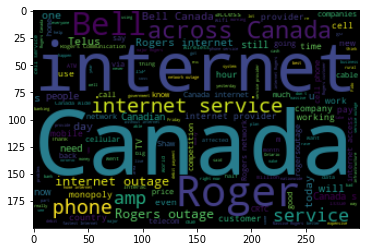

In [318]:
# WordCloud showing the most common words in our dataset
# Obviously the internet service provider come back (keywords in fetch from API)
# Others major include : Rogers outage, internet etc...

from wordcloud import WordCloud

allWords = ' '.join([t for t in df['tweets']])
wordCloud = WordCloud(width = 300, height=200, random_state = 21, max_font_size = 120).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')

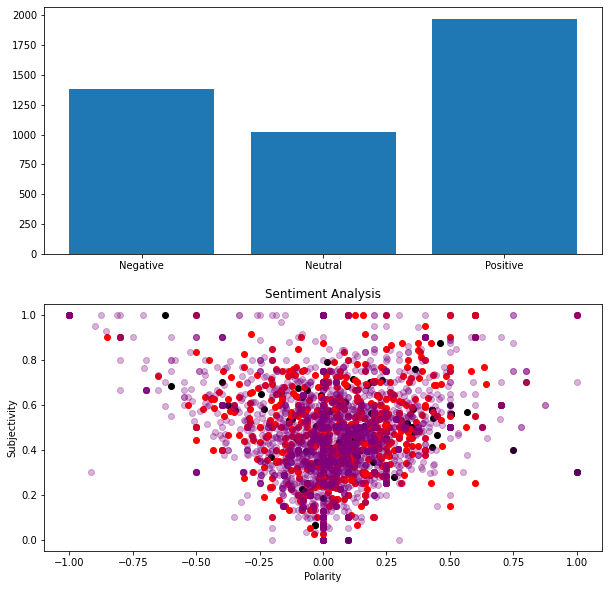

In [320]:
# Results:
## 1- Rogers has the biggest datapoints portion in this dataset,  negative tweets are close to positive however, the positive are the higher
## 2- Telus the datapoints is bias toward the positive 

x = df[df['ISP'] == 'Telus']['Pol'] ## black
y = df[df['ISP'] == 'Telus']['Sub']

x1 = df[df['ISP'] == 'Bell']['Pol'] ## red
y1 = df[df['ISP'] == 'Bell']['Sub']

x2 = df[df['ISP'] == 'Rogers']['Pol'] ## Purple
y2 = df[df['ISP'] == 'Rogers']['Sub']

sub1 = df.groupby('Score').agg({'tweets': ['count']})

for index, row in sub1.iterrows():
    sub1.loc[index,'%'] = (int(row['tweets'][0]) / int(sub1['tweets'].sum()))*100

x3 = []
y3 = []
    
for j in sub1.index.values:
    x3.append(j)

for i in sub1.tweets.values:
    y3.append(i[0])
    
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].bar(x3,y3)
ax[1].scatter(x,y,color='Black')
ax[1].scatter(x1,y1,color='Red')
ax[1].scatter(x2,y2,color='Purple', alpha = .3)

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.show()


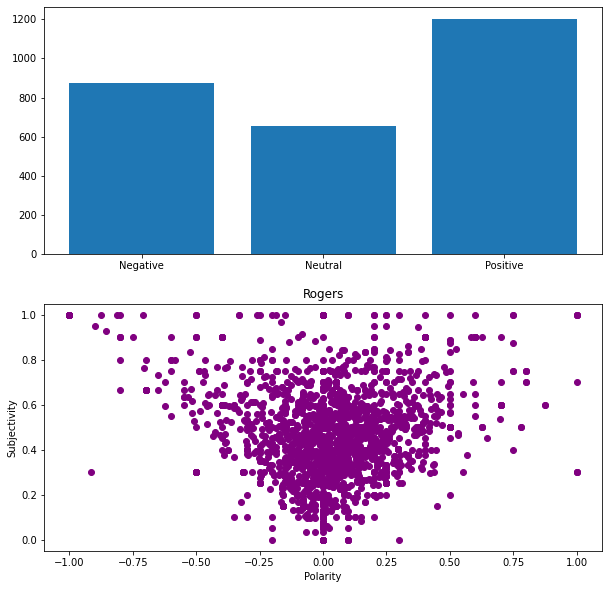

In [321]:
# Results:
## 1- Although the Rogers has lots tweets and mainly during rogers outage in July the overall sentimental analysis shows the tweets were positive over the whole dataset
x = df[df['ISP'] == 'Rogers']['Pol']
y = df[df['ISP'] == 'Rogers']['Sub']

sub = df[df['ISP'] == 'Rogers']
sub1 = sub.groupby('Score').agg({'tweets': ['count']})

for index, row in sub1.iterrows():
    sub1.loc[index,'%'] = (int(row['tweets'][0]) / int(sub1['tweets'].sum()))*100

x1 = []
y1 = []
    
for j in sub1.index.values:
    x1.append(j)

for i in sub1.tweets.values:
    y1.append(i[0])
    
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].bar(x1,y1)
ax[1].scatter(x,y,color='Purple')

plt.title('Rogers')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.show()


In [323]:
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [324]:
## word_tokenize is to split a sentence into tokens or words

STOP_WORDS = stopwords.words()
def cleaning (text):
 text_tokens = word_tokenize(text)
 tokens_without_sw = [word for word in text_tokens if not word in STOP_WORDS]
 filtered_sentence = (" ").join(tokens_without_sw)
 text = filtered_sentence
 return text


In [325]:
df['tweets'] = df['tweets'].apply(cleaning)
df

,date,tweets,ISP,Sub,Pol,Score
0,2022-09-09,_Thompson It 's locals nicknamed telecom compa...,Rogers,0.541667,0.358333,Positive
1,2022-09-09,On May 29BELL CANADA assured install fibre opt...,BELL,0.000000,0.000000,Neutral
2,2022-09-09,It huge mistake switching fiber internet . The...,bell,0.633333,-0.200000,Negative
3,2022-09-09,Is countermeasure canadian internet blackout c...,Rogers,0.494444,0.322222,Positive
4,2022-09-08,Canada Commends 'Calming ' Cash Following majo...,Rogers,0.200000,0.020833,Positive
...,...,...,...,...,...,...
4358,2021-01-04,Thanks . Pay highest quality internet month ch...,Bell,0.466667,-0.333333,Negative
4359,2021-01-04,_canada_ Can André Beaulieu Bell Nexia 's lowe...,Bell,0.288889,0.166667,Positive
4360,2021-01-04,I Bell Canada highspeed internet 🙄,Bell,0.000000,0.000000,Neutral
4361,2021-01-03,What Hell Shaw ? I 've uninterrupted Internet ...,Bell,0.512500,-0.212500,Negative


In [326]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
# from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report



In [327]:
## TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words.
## apply TfidfVectorizer - CountVectorizer & TfidfTransformer in one step!

tf = TfidfVectorizer()                #Create an instance of our TfidfVectorize()

X = df['tweets']
y = df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

X_train = tf.fit_transform(X_train)  #fit_transform on training data
X_test = tf.transform(X_test)        #transform on testing data ƒ

In [328]:
log_model = LogisticRegression(max_iter=1000) ##### 

log_model.fit(X_train,y_train)           

preds = log_model.predict(X_test)

print(classification_report(y_test,preds))


# To optimize BoW - more pre-processing word cleaning is required 
# ie. stop word removal and/or stemming/lemmatization 
# Otherwise words that frequently appear in our documents will have little to no predictive power ('a', 'the', etc.)

              precision    recall  f1-score   support

    Negative       0.66      0.50      0.57       418
     Neutral       0.71      0.47      0.57       295
    Positive       0.61      0.81      0.70       596

    accuracy                           0.64      1309
   macro avg       0.66      0.60      0.61      1309
weighted avg       0.65      0.64      0.63      1309



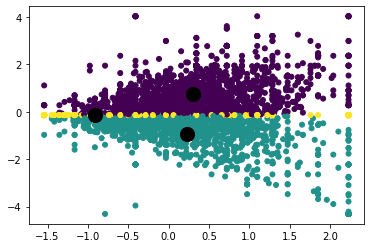

In [329]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Here we are applying clustering,
# the result of clustering gives us 3 distinct groups but it isn't isolated, very close to each other


x = df

X = x.drop(['tweets','ISP','date'],axis=1)

cat_cols = ['Score']

for col in cat_cols:
    X = X.join(pd.get_dummies(X[col], prefix=col)) 

X = X.drop(['Score'],axis=1)

# normalizing data
X = StandardScaler().fit_transform(X)

N_CLUSTERS = 3
    
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)    

centers = kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=25, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200)
plt.show()

In [ ]:
### to install Flask application to present my code

In [341]:
# ### Based on the frequancy of words, Competitors can reached the Vulnerable customers

from collections import Counter
# #after cleaning the data;
word_count = Counter(" ".join(df['tweets']).split()).most_common(30)
word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
word_frequency

word_frequency['Word'] = word_frequency['Word'].apply(removeStuff)
word_frequency

,Word,Frequency
0,.,5888
1,",",4823
2,Canada,3935
3,internet,3647
4,Rogers,2803
5,I,1492
6,’,1284
7,outage,1154
8,!,1107
9,Internet,1016


In [285]:
## Save the model for delpoyment

import pickle

# Saving our model 
file_name = 'ISP_model'

with open(file_name, 'wb') as file:
    pickle.dump(log_model,file)